# Testing Zero-Inflated Count Matrix Factorization in Darmanis data 

In [2]:
from pCMF.misc import utils, plot_utils
from pCMF.models.pcmf.inferences import cavi_new, svi_new

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, classification_report, accuracy_score
from sklearn.model_selection import train_test_split

import pandas as pd
from scipy.stats import gamma

import operator
import seaborn as sns
sns.set_style('whitegrid')

In [4]:
brain_tags = pd.read_csv('../../data/Brain/brainTags.csv')

In [5]:
brain_tags.rename(columns={'Unnamed: 0': 'Gene name'}, inplace=True)

In [6]:
gene_names = brain_tags['Gene name']

In [7]:
brain_tags = brain_tags.drop('Gene name', axis=1)

In [8]:
np.count_nonzero(brain_tags['GSM1657871'] == 0)

17862

In [9]:
brain_tags_np = np.array(brain_tags)

In [10]:
info = pd.read_csv('../../data/Brain/SraRunTable.txt', sep='\t')

In [11]:
mapping = [list(info.Sample_Name_s).index(cell_name) if cell_name in list(info.Sample_Name_s) else None for cell_name in list(brain_tags.columns)]

In [12]:
cell_type = info.cell_type_s[mapping]

In [54]:
types, labels = np.unique(cell_type, return_inverse=True)

In [57]:
## Assign each cell a color according to its type
scols = ["red","blue","green","brown","pink","purple","darkgreen","grey"]
cols = []
for i in range(len(cell_type)):
    cols.append(scols[np.argwhere(list(cell_type)[i]==types)[0][0]])

In [58]:
cell_type[cell_type == types[0]] = "fetal quiescent"
cell_type[cell_type == types[1]] = "fetal replicating"
#cell_type[cell_type == types[-1]] = "oligodendrocyte precursor cells"

# Change to clearer cell type names
types[0] = "fetal quiescent"
types[1] = "fetal replicating"
#types[-1] = "oligodendrocyte precursor cells"

In [16]:
brain_10 = brain_tags[np.sum(brain_tags, axis=1) > 10]  # remove genes with zero expression across all cells

In [18]:
brain_10.shape

(18565, 420)

In [32]:
expression = np.array(brain_10).T

In [33]:
expression.shape

(420, 18565)

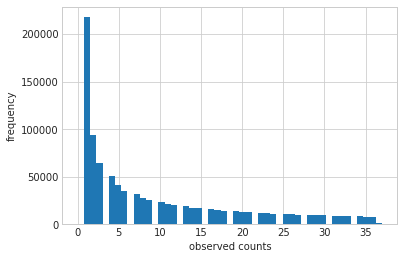

In [44]:
sortedex = np.sort(expression.flatten())[:int(0.9*expression.size)]

bins = np.linspace(0, sortedex.max(), num=50)

plt.hist(sortedex[sortedex>0], bins)
plt.xlabel('observed counts')
plt.ylabel('frequency')
plt.show()

In [59]:
#train/test split
X_train, X_test, c_train, c_test = train_test_split(expression, labels)

In [60]:
T = 60. * 30.
S = 30.
max_iter = 1000000

In [61]:
P = expression.shape[1]
K = 10 # latent space dimensionality
C = np.unique(c_train)

In [62]:
# Run PCA
pca_U = PCA(n_components=K).fit_transform(np.log(X_train + 1.))
pca_tsne = TSNE(n_components=2).fit_transform(pca_U)

In [63]:
# Prior parameters
alpha = np.ones((2, K))
alpha[0, :] = 3.
alpha[1, :] = 0.5
beta = np.ones((2, P, K))
pi_D = np.ones((P,)) * 0.5

In [64]:
print('Stochastic Simple GaP-EB:')
infgapeb = svi_new.StochasticVI(X_train, alpha, beta, minibatch_size=100, empirical_bayes=True)
infgapeb.run(n_iterations=max_iter, calc_ll=True, calc_silh=True, clusters=c_train, sampling_rate=S, max_time=T)
gapeb_U = infgapeb.a[0] / infgapeb.a[1] # VI estimate is the mean of the variational approximation
gapeb_V = infgapeb.b[0] / infgapeb.b[1]
gapeb_D = infgapeb.estimate_D(infgapeb.p_D)
gapeb_S = infgapeb.estimate_S(infgapeb.p_S)
gapeb_tsne = TSNE(n_components=2).fit_transform(gapeb_U)

Stochastic Simple GaP-EB:


/home/pferreira/pCMF/pCMF/misc/utils.py:97: RuntimeWarning: divide by zero encountered in log
  ll[idx] = np.log(1.-est_p_D[idx] + est_p_D[idx] * np.exp(-param[idx]))


Iteration 4/1000000. Log-likelihood: -inf. Elapsed: 2021 seconds


In [65]:
print('Stochastic Zero-Inflated GaP-EB:')
infzigapeb = svi_new.StochasticVI(X_train, alpha, beta, pi_D=pi_D, minibatch_size=100, empirical_bayes=True)
infzigapeb.run(n_iterations=max_iter, calc_ll=True, calc_silh=True, clusters=c_train, sampling_rate=S, max_time=T)
zigapeb_U = infzigapeb.a[0] / infzigapeb.a[1] # VI estimate is the mean of the variational approximation
zigapeb_V = infzigapeb.b[0] / infzigapeb.b[1]
zigapeb_D = infzigapeb.estimate_D(infzigapeb.p_D)
zigapeb_S = infzigapeb.estimate_S(infzigapeb.p_S)
zigapeb_tsne = TSNE(n_components=2).fit_transform(zigapeb_U)

Stochastic Zero-Inflated GaP-EB:
Iteration 4/1000000. Log-likelihood: 98.012. Elapsed: 2228 secondss


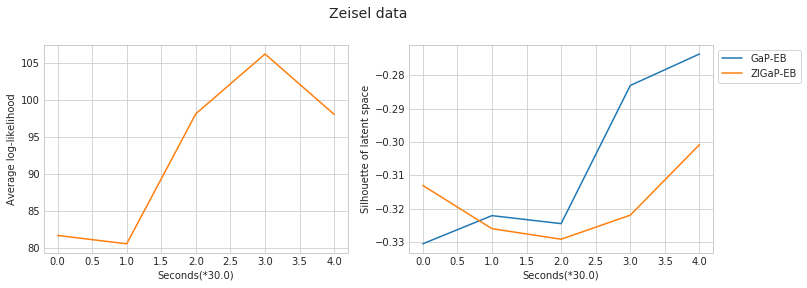

In [66]:
fig = plt.figure(figsize=(12, 4))

ax = plt.subplot(1, 2, 1)
ax.plot(infgapeb.ll_time, label='GaP-EB')
ax.plot(infzigapeb.ll_time, label='ZIGaP-EB')
plt.ylabel('Average log-likelihood')
plt.xlabel('Seconds(*{0})'.format(S))

ax = plt.subplot(1, 2, 2)
ax.plot(infgapeb.silh_time, label='GaP-EB')
ax.plot(infzigapeb.silh_time, label='ZIGaP-EB')
plt.ylabel('Silhouette of latent space')
plt.xlabel('Seconds(*{0})'.format(S))

plt.legend(loc='upper left', bbox_to_anchor=[1., 1.], frameon=True)
plt.suptitle('Zeisel data', fontsize=14)
plt.subplots_adjust(top=0.85)
plt.show()

In [67]:
gapeb_dll = utils.log_likelihood(X_train, gapeb_U, gapeb_V, infgapeb.p_D, gapeb_S)
zigapeb_dll = utils.log_likelihood(X_train, zigapeb_U, zigapeb_V, infzigapeb.p_D, zigapeb_S)

scores = {'GaP-EB': gapeb_dll, 'ZIGaP-EB': zigapeb_dll}

sorted_scores = sorted(scores.items(), key=operator.itemgetter(1), reverse=True)

print('Full data log-likelihood:')
print('\033[1m- {0}: {1:.3}\033[0m'.format(sorted_scores[0][0], sorted_scores[0][1]))
for score_tp in sorted_scores[1:]:
    print('- {0}: {1:.3}'.format(score_tp[0], score_tp[1]))

/home/pferreira/pCMF/pCMF/misc/utils.py:97: RuntimeWarning: divide by zero encountered in log
  ll[idx] = np.log(1.-est_p_D[idx] + est_p_D[idx] * np.exp(-param[idx]))


Full data log-likelihood:
- GaP-EB: -inf
- ZIGaP-EB: -inf


In [68]:
gapeb_holl = infgapeb.predictive_ll(X_test)
zigapeb_holl = infzigapeb.predictive_ll(X_test)

scores = {'GaP-EB': gapeb_holl, 'ZIGaP-EB': zigapeb_holl}

sorted_scores = sorted(scores.items(), key=operator.itemgetter(1), reverse=True)

print('Held-out log-likelihood:')
print('\033[1m- {0}: {1:.3}\033[0m'.format(sorted_scores[0][0], sorted_scores[0][1]))
for score_tp in sorted_scores[1:]:
    print('- {0}: {1:.3}'.format(score_tp[0], score_tp[1]))

/home/pferreira/pCMF/pCMF/misc/utils.py:97: RuntimeWarning: divide by zero encountered in log
  ll[idx] = np.log(1.-est_p_D[idx] + est_p_D[idx] * np.exp(-param[idx]))


KeyboardInterrupt: 

In [ ]:
true_silh = silhouette_score(U_train, c_train)
gapeb_silh = silhouette_score(gapeb_U, c_train)
zigapeb_silh = silhouette_score(zigapeb_U, c_train)
pca_silh = silhouette_score(pca_U, c_train)

scores = {'GaP-EB': gapeb_silh, 'ZIGaP-EB': zigapeb_silh, 'PCA': pca_silh}

sorted_scores = sorted(scores.items(), key=operator.itemgetter(1), reverse=True)

print('Silhouette scores (higher is better):')
print('\033[1m- {0}: {1:.3}\033[0m'.format(sorted_scores[0][0], sorted_scores[0][1]))
for score_tp in sorted_scores[1:]:
    print('- {0}: {1:.3}'.format(score_tp[0], score_tp[1]))
    
print('\nSilhouette of true U:')
print('%0.3f' % true_silh)

In [ ]:
# Plot in decreasing silhouette order
U_list = [gap_tsne, gapeb_tsne, zigap_tsne, zigapeb_tsne, pca_tsne]
title_list = ['GaP-EB','ZIGaP-EB', 'PCA']

assert len(U_list) == len(title_list)

n_results = len(U_list)

fig = plt.figure(figsize=(16, 4))

s = 30
alpha = 0.7
labels=None
for i in range(len(U_list)):
    ax = plt.subplot(1, n_results, i+1)
    handlers = []
    for c in range(C):
        h = ax.scatter(U_list[title_list.index(sorted_scores[i][0])][c_train==c, 0], U_list[title_list.index(sorted_scores[i][0])][c_train==c, 1], s=s, alpha=alpha)
        handlers.append(h)
    if labels is not None:
        ax.legend(handlers, labels, scatterpoints=1)
    plt.title(sorted_scores[i][0])
plt.show()

# Dropout identification and imputation
The held-out likelihood is only useful for data which isn't dominated by zeros. When it is, higher likelihoods will be obtained by models which place more mass at zero, which is not the comparison we want to make. In this case then, we evaluate the ability of the model to impute dropped out values.

To evaluate imputation ability on the real data set, we first corrupt the original data with extra dropouts on non-zero observations and infer a new pCMF model on the corrupted data set.

We know what entries are dropouts because we have simulated them, and we also know the true value behind it.

First, we check if the model has identified dropouts well.

Then, we replace each dropout with the value the model finds to be most likely and compare it with the true value. For pCMF, imputing the entry $Y_{ij}$ corresponds to setting it to $U_iV_j $.

In [ ]:
dropout_idx = np.where(D_train == 0)

## Dropout identification

In [ ]:
gapeb_dropid = accuracy_score(gapeb_D.flatten(), D_train.flatten())
zigapeb_dropid = accuracy_score(zigapeb_D.flatten(), D_train.flatten())

scores = {'GaP-EB': gapeb_dropid, 'ZIGaP-EB': zigapeb_dropid}

sorted_scores = sorted(scores.items(), key=operator.itemgetter(1), reverse=True)

print('Dropout identification accuracy (higher is better):')
print('\033[1m- {0}: {1:.3}\033[0m'.format(sorted_scores[0][0], sorted_scores[0][1]))
for score_tp in sorted_scores[1:]:
    print('- {0}: {1:.3}'.format(score_tp[0], score_tp[1]))

## Dropout imputation 

In [ ]:
# Use the posterior Poisson mean
gapeb_R = np.dot(gapeb_U, gapeb_V.T)
zigapeb_R = np.dot(zigapeb_U, zigapeb_V.T)

In [ ]:
# Compute the imputation error on the data entries we know to be dropouts
gapeb_err = utils.imputation_error(X_train, gapeb_R, dropout_idx)
zigapeb_err = utils.imputation_error(X_train, zigapeb_R, dropout_idx)

scores = {'GaP-EB': gapeb_err, 'ZIGaP-EB': zigapeb_err}

sorted_scores = sorted(scores.items(), key=operator.itemgetter(1), reverse=False)

print('Dropout imputation error (lower is better):')
print('\033[1m- {0}: {1:.3}\033[0m'.format(sorted_scores[0][0], sorted_scores[0][1]))
for score_tp in sorted_scores[1:]:
    print('- {0}: {1:.3}'.format(score_tp[0], score_tp[1]))

In [ ]:
R_list = [gapeb_R, zigapeb_R]
title_list = ['GaP-EB', 'ZIGaP-EB']

fig = plt.figure(figsize=(10, 4))

s = 30
alpha = 0.7
labels=None
for i in range(len(R_list)):
    ax = plt.subplot(1, n_results, i+1)
    plot_utils.plot_imputation_density(
        R_list[title_list.index(sorted_scores[i][0])], X_train, dropout_idx, ymax=50, 
        ax=ax, title=sorted_scores[i][0])
plt.show()